In this notebook we are creating a binary SDGClassifier to classify between wrist flexion and ulnar deviation. As these to actions require a similar muscles group, we are intrested to know wether our fetaures show any distinct behaviour in these gestures. We are using LPCC and MFCC from all the channels as our Data for this classifier.

SGD stands for Stochastic Gradient Descent. As the name suggests this is a linear algorithm based on the princilpe of Gradient Descent. Furthermore, this algorithm trains its model taking random instances from our dataset rather than using the entire dataset so it got its name Stochastic Gradient Descent.

Now let us start by reading the features dataframe and building the metrices X and y with required features and labels respectively. This Notebook is built in Google Colab so for local users line 2 may not be relevant.


In [ ]:
#importing some common libraries 
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import matplotlib

In [ ]:
#for downloading files in google colab from google drive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

downloaded = drive.CreateFile({'id':'1spjlxMKsa5thVk8ev3HY1GV4HX2qP4P-'})  
downloaded.GetContentFile('sEMG_Features.csv')

In [ ]:
#selecting features 
DF = pd.read_csv('sEMG_Features.csv', index_col=[0])

In [ ]:
#selecting wrist flexion and ulnar deviation 
df = DF[DF.group == 3].copy()
df = df.append(DF[DF.group ==5 ])

In [ ]:
#selecting LPCC and MFCC from all the channels
df.reset_index(inplace=True,drop=True)
df = df [['0_LPCC_0', '0_LPCC_1', '0_MFCC_0', '1_LPCC_0', '1_LPCC_1', '1_MFCC_0', '2_LPCC_0', '2_LPCC_1', '2_MFCC_0','3_LPCC_0', '3_LPCC_1', '3_MFCC_0','4_LPCC_0', '4_LPCC_1', '4_MFCC_0','5_LPCC_0', '5_LPCC_1', '5_MFCC_0','6_LPCC_0', '6_LPCC_1', '6_MFCC_0','7_LPCC_0', '7_LPCC_1', '7_MFCC_0', 'group']]

In [ ]:
#randomising the dataframe
df = df.sample(frac=1, random_state=42)
df

0_LPCC_0  0_LPCC_1      0_MFCC_0  ...  7_LPCC_1      7_MFCC_0  group
1558  0.040526  0.403983 -1.000000e-08  ...  0.647298 -1.000000e-08      3
3057  0.166990  0.828707 -1.000000e-08  ...  0.326058 -1.000000e-08      3
8229  0.795852  1.904556 -1.000000e-08  ...  3.318061 -9.999994e-09      5
5354  0.335583  1.191247 -1.000000e-08  ...  0.953511 -1.000000e-08      5
35    0.069129  0.528881 -1.000000e-08  ...  0.598672 -1.000000e-08      3
...        ...       ...           ...  ...       ...           ...    ...
5734  0.010059  0.200753 -1.000000e-08  ...  0.402008 -1.000000e-08      5
5191  0.000029  0.010781 -1.000000e-08  ...  0.291864 -1.000000e-08      5
5390  0.034682  0.373542 -1.000000e-08  ...  0.364850 -1.000000e-08      5
860   0.121125  0.703107 -1.000000e-08  ...  0.479355 -1.000000e-08      3
7270  0.000694  0.052704 -1.000000e-08  ...  0.618927 -1.000000e-08      5

[9988 rows x 25 columns]

In [ ]:
#creating X, y matrices of the data 
y = df.pop('group').values
X = df.values
print(X.shape, y.shape)

(9988, 24) (9988,)


Now that we have our data metrices in X and y we are ready to build our classifiers. Note that Gradient Descent algorithm requires all the features to be scaled. If it is not done then the cost function of Gradient Descent gets elongated according to varying scales of the features and will take a very long time to reach the optimal solution for the model.

We are used StandardScaler function provided by scikit-learn to scale our dataset to a standard scale. This scaler standardizes the features by removing the mean from the data and scaling it to unit variance.

In [ ]:
#importing and applying standard scaler
from sklearn.preprocessing import StandardScaler

#scaling the X matrix
std_scaler = StandardScaler()
X_s = std_scaler.fit_transform(X)

Now we have our data scaled let us split it the data for training and testing. We are using train_test_split function provided by scikit-learn. This function subsamples the data and splits it into desired ratio. We are sampling our data in the ration 0.8:0.2 for training and testing respectively. Since the features for our two gestures is in imbalanced lengths we are using stratified sampaling.

In [ ]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X_s,y, test_size=0.2, random_state = 42, stratify = y)

Now let us build an optimal SGDClassifier which gives us maximum results for our input metrices. For this we shall be using GridSearchCV provided by scikit-learn which trains the models for us using the provided list dictionary of parameters, trains them, compares them and gives us the best parameters for our classifer from the list of dictionary we provided.
Regularization is needed in liner classification algorithm as it helps us to reduce the overfitting of data. There are three diffrent ways of regularizaion which are :

* Ridge Regression: It regularises the linear regression by adding the alpha times sum of squre of weights of the features to the cost function of Gradient Descent.This forces the learning algorithm to
not only fit the data but also keep the model weights as small as possible. It's hyperparameter alpha to control the regularization. Penalty 'l2' specifies Ridge Regression which is default for SFGClassifier.

* Lasso Regression: It is another version of regularized Linear Regression and adds its regularization term (alpha times sum of weights) to the cost function. An important characteristic of Lasso Regression is that it tends to completely eliminate the weights of the
least important features. Penalty 'l1' specifies Ridge Regression.

* Elastic Net: It is the middle ground between Regression and Lasso Regression. The regularization term is a simple mix of both Ridge and Lasso’s regularization terms given by 'l1_ratio' hyperparameter. 

We create a list of dictionary of hyperparameters for all these regularizations and search for the best regularization for our classifier.

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import SGDClassifier

#creating list of dictionaries with various values for hyper parameters
parm_grid = [{'max_iter': [1000,2000,3000,4000,5000], 'alpha': [0.0001,0.001,0.01, 0.00001], 'tol': [1e-3, 1e-4, 1e-5]},
              {'penalty':['l1'], 'max_iter': [1000,2000,3000,4000,5000], 'alpha': [0.0001,0.001,0.01, 0.00001], 'tol': [1e-3, 1e-4, 1e-5]},
              {'penalty':['elasticnet'], 'l1_ratio': [0.1, 0.15, 0.2],'max_iter': [1000,2000,3000,4000,5000], 'alpha': [0.0001,0.001,0.01, 0.00001], 'tol': [1e-3, 1e-4, 1e-5]},]
sgd_clf = SGDClassifier()
grid_searh  = GridSearchCV(sgd_clf, parm_grid, scoring = 'roc_auc')

In [ ]:
#training our data using grid search for best parameter
grid_searh.fit(X_train,y_train)

GridSearchCV(cv=None, error_score=nan,
             estimator=SGDClassifier(alpha=0.0001, average=False,
                                     class_weight=None, early_stopping=False,
                                     epsilon=0.1, eta0=0.0, fit_intercept=True,
                                     l1_ratio=0.15, learning_rate='optimal',
                                     loss='hinge', max_iter=1000,
                                     n_iter_no_change=5, n_jobs=None,
                                     penalty='l2', power_t=0.5,
                                     random_state=None, shuffle=True, tol=0.001,
                                     validation_fraction=0...
                         {'alpha': [0.0001, 0.001, 0.01, 1e-05],
                          'max_iter': [1000, 2000, 3000, 4000, 5000],
                          'penalty': ['l1'], 'tol': [0.001, 0.0001, 1e-05]},
                         {'alpha': [0.0001, 0.001, 0.01, 1e-05],
                          'l1_ratio': [0

In [ ]:
grid_searh.best_params_

{'alpha': 0.001,
 'l1_ratio': 0.1,
 'max_iter': 2000,
 'penalty': 'elasticnet',
 'tol': 0.001}

In [ ]:
grid_searh.best_estimator_

SGDClassifier(alpha=0.001, average=False, class_weight=None,
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.1, learning_rate='optimal', loss='hinge',
              max_iter=2000, n_iter_no_change=5, n_jobs=None,
              penalty='elasticnet', power_t=0.5, random_state=None,
              shuffle=True, tol=0.001, validation_fraction=0.1, verbose=0,
              warm_start=False)

Here we have seen that Ridge Regression  with aplha =  0.001 gives us the best classifier. The selection of ElasticNet as best regularization indicates that all our features that we choosed are partially important for producing better results. As, lasso regression doesn't work well with inter-realted set of features while our features LPCC_0 and LPCC_1 are related to eachother, the use of elasticnet over lasso is justified.

Let us also view the Root Mean Score for all the other tuning parameters.

In [ ]:
cvres = grid_searh.cv_results_
for mean_score, params in zip(cvres["mean_test_score"],cvres["params"]):
    print(np.sqrt(mean_score), params)

0.7154937448809691 {'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.001}
0.7139951434648506 {'alpha': 0.0001, 'max_iter': 1000, 'tol': 0.0001}
0.7061371225826647 {'alpha': 0.0001, 'max_iter': 1000, 'tol': 1e-05}
0.71390605290383 {'alpha': 0.0001, 'max_iter': 2000, 'tol': 0.001}
0.7121579885100058 {'alpha': 0.0001, 'max_iter': 2000, 'tol': 0.0001}
0.7075526226407692 {'alpha': 0.0001, 'max_iter': 2000, 'tol': 1e-05}
0.7046375105407693 {'alpha': 0.0001, 'max_iter': 3000, 'tol': 0.001}
0.700919627553023 {'alpha': 0.0001, 'max_iter': 3000, 'tol': 0.0001}
0.6969030783486513 {'alpha': 0.0001, 'max_iter': 3000, 'tol': 1e-05}
0.7070806427201505 {'alpha': 0.0001, 'max_iter': 4000, 'tol': 0.001}
0.715384557455687 {'alpha': 0.0001, 'max_iter': 4000, 'tol': 0.0001}
0.7056709667621621 {'alpha': 0.0001, 'max_iter': 4000, 'tol': 1e-05}
0.7034879432830974 {'alpha': 0.0001, 'max_iter': 5000, 'tol': 0.001}
0.7149863032647661 {'alpha': 0.0001, 'max_iter': 5000, 'tol': 0.0001}
0.7071579590003526 {'alpha': 0.00

Now Lets select the best classifier and use it on our training sets to see its performance.

In [ ]:
#selecting the model
final_model = grid_searh.best_estimator_

In [ ]:
#using the model on training set and testing its performance 
from sklearn.metrics import roc_auc_score
y_train_pred = final_model.predict(X_train)
train_score = roc_auc_score(y_train, y_train_pred)
print(train_score)

0.5174124593099203


Well our performance is very low as expected. Lets us check the confusion matrix to see why our performance is this low.

In [ ]:
from sklearn.metrics import confusion_matrix

train_conf = confusion_matrix(y_train, y_train_pred)
train_conf

array([[2175, 1801],
       [2056, 1958]])

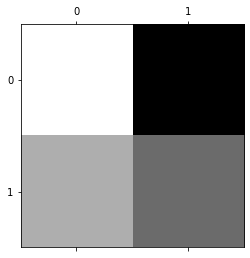

In [ ]:
plt.matshow(train_conf, cmap = matplotlib.cm.gray)
plt.show()

This nature of confusion matrix plot signifies that most of the ulnar deviation was confused as wrist flexion. Our expectaion was white diagonal across (0,0) and (1,1) and black diagonal across (0,1) and (1,0). So, either the features of these two gestures are too similar or the linear model is not a better suited model for our research. 

Finally check the performance on the test dataset.

In [ ]:
y_test_pred = final_model.predict(X_test)

final_score = roc_auc_score(y_test, y_test_pred)
print('The Final ROC score is :',final_score)

The Final ROC score is : 0.5056233817246106


Hence, we got ROC score (Area under the ROC curve) as 0.5056 which is significantly low as per our need.

